In [1]:
pip install PyWavelets

Note: you may need to restart the kernel to use updated packages.


100%|██████████| 170498071/170498071 [00:01<00:00, 99115407.98it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Finished Training


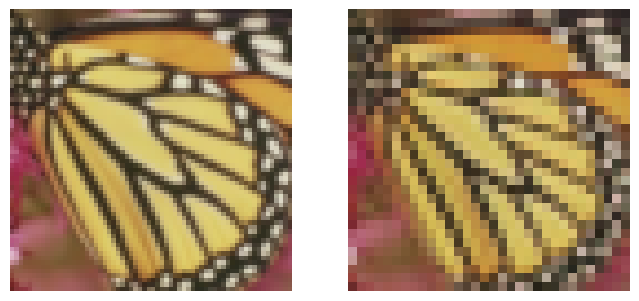

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
!pip install PyWavelets
import pywt
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn.functional as F

class WaveletTransform(nn.Module):
    def __init__(self):
        super(WaveletTransform, self).__init__()

    def forward(self, x):
        batch_size, channels, height, width = x.size()
        wavelet_coeffs = torch.zeros((batch_size, channels * 4, height, width), dtype=torch.float32).to(x.device)
        for i in range(batch_size):
            for j in range(channels):
                img = x[i, j].cpu().numpy()
                coeffs2 = pywt.dwt2(img, 'haar')
                LL, (LH, HL, HH) = coeffs2
                LL_resized = torch.tensor(LL).unsqueeze(0).to(x.device)
                LH_resized = torch.tensor(LH).unsqueeze(0).to(x.device)
                HL_resized = torch.tensor(HL).unsqueeze(0).to(x.device)
                HH_resized = torch.tensor(HH).unsqueeze(0).to(x.device)
                LL_resized = F.interpolate(LL_resized.unsqueeze(0), size=(height, width), mode='bilinear', align_corners=False).squeeze(0)
                LH_resized = F.interpolate(LH_resized.unsqueeze(0), size=(height, width), mode='bilinear', align_corners=False).squeeze(0)
                HL_resized = F.interpolate(HL_resized.unsqueeze(0), size=(height, width), mode='bilinear', align_corners=False).squeeze(0)
                HH_resized = F.interpolate(HH_resized.unsqueeze(0), size=(height, width), mode='bilinear', align_corners=False).squeeze(0)
                wavelet_coeffs[i, 4*j+0] = LL_resized
                wavelet_coeffs[i, 4*j+1] = LH_resized
                wavelet_coeffs[i, 4*j+2] = HL_resized
                wavelet_coeffs[i, 4*j+3] = HH_resized
        return wavelet_coeffs

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(out_channels)
        self.match_dimensions = nn.Conv2d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else None

    def forward(self, x):
        residual = x
        if self.match_dimensions is not None:
            residual = self.match_dimensions(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.conv3(out)
        out = self.bn3(out)
        out += residual
        return self.relu(out)

class SubpixelDecoder(nn.Module):
    def __init__(self, in_channels, out_channels, upscale_factor=2):
        super(SubpixelDecoder, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels * (upscale_factor ** 2), kernel_size=3, padding=1)
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.pixel_shuffle(x)
        return self.relu(x)

class EnhancedSeriesAutoencoder(nn.Module):
    def __init__(self):
        super(EnhancedSeriesAutoencoder, self).__init__()
        self.wavelet = WaveletTransform()
        self.encoder1 = ResidualBlock(12, 64)
        self.encoder2 = ResidualBlock(64, 128)
        self.encoder3 = ResidualBlock(128, 256)
        self.encoder4 = ResidualBlock(256, 512)
        self.decoder4 = SubpixelDecoder(512, 256)
        self.decoder3 = SubpixelDecoder(256, 128)
        self.decoder2 = SubpixelDecoder(128, 64)
        self.decoder1 = SubpixelDecoder(64, 12)
        self.final_conv = nn.Conv2d(12, 3, kernel_size=3, padding=1)

    def forward(self, x):
        wavelet_components = self.wavelet(x)
        enc1 = self.encoder1(wavelet_components)
        enc2 = self.encoder2(enc1)
        enc3 = self.encoder3(enc2)
        enc4 = self.encoder4(enc3)
        dec4 = self.decoder4(enc4)
        dec3 = self.decoder3(dec4 + F.interpolate(enc3, size=dec4.shape[2:], mode='bilinear', align_corners=False))
        dec2 = self.decoder2(dec3 + F.interpolate(enc2, size=dec3.shape[2:], mode='bilinear', align_corners=False))
        dec1 = self.decoder1(dec2 + F.interpolate(enc1, size=dec2.shape[2:], mode='bilinear', align_corners=False))
        output = self.final_conv(dec1)
        output = F.interpolate(output, size=(32, 32), mode='bilinear', align_corners=False)
        return output

transform = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
subset_indices = np.random.choice(len(train_dataset), 500, replace=False)
train_subset = Subset(train_dataset, subset_indices)
train_loader = DataLoader(train_subset, batch_size=64, shuffle=True, num_workers=2)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
enhanced_series_model = EnhancedSeriesAutoencoder().to(device)
optimizer = optim.Adam(enhanced_series_model.parameters(), lr=0.0002)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5)
criterion = nn.MSELoss()

def train_model(model, dataloader, optimizer, scheduler, num_epochs=100):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (inputs, _) in enumerate(dataloader, 0):
            inputs = inputs.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if i % 100 == 99:
                print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {running_loss / 100:.4f}')
                running_loss = 0.0
        scheduler.step()
    print('Finished Training')

def load_image(image_path):
    img = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    img_tensor = transform(img).unsqueeze(0)
    return img_tensor

def denormalize(tensor):
    tensor = tensor * 0.5 + 0.5
    return tensor.clamp(0, 1)

def display_images(original, compressed):
    original_img = np.transpose(original.squeeze(0).cpu().numpy(), (1, 2, 0))
    compressed_img = np.transpose(compressed.squeeze(0).cpu().detach().numpy(), (1, 2, 0))
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    axs[0].imshow(original_img)
    axs[0].axis('off')
    axs[1].imshow(compressed_img)
    axs[1].axis('off')
    plt.show()

def compress_and_display_image(image_path, model):
    image_tensor = load_image(image_path).to(device)
    model.eval()
    with torch.no_grad():
        compressed_tensor = model(image_tensor)
    original_img = denormalize(image_tensor)
    compressed_img = denormalize(compressed_tensor)
    display_images(original_img, compressed_img)

train_model(enhanced_series_model, train_loader, optimizer, scheduler, 100)

image_path = '/kaggle/input/sdfghjk/image1.png'
compress_and_display_image(image_path, enhanced_series_model)

100%|██████████| 170498071/170498071 [00:01<00:00, 95088370.21it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Epoch 1/100, Loss: 0.1106, Train PSNR: 11.19, Train SSIM: 0.2656, Val PSNR: 8.23, Val SSIM: 0.0676, Train MAE: 0.0040, Val MAE: 0.0069
Epoch 2/100, Loss: 0.1240, Train PSNR: 9.80, Train SSIM: 0.1729, Val PSNR: 11.68, Val SSIM: 0.2745, Train MAE: 0.0046, Val MAE: 0.0043
Epoch 3/100, Loss: 0.0531, Train PSNR: 13.22, Train SSIM: 0.3273, Val PSNR: 14.61, Val SSIM: 0.4131, Train MAE: 0.0029, Val MAE: 0.0030
Epoch 4/100, Loss: 0.0334, Train PSNR: 15.25, Train SSIM: 0.4911, Val PSNR: 15.58, Val SSIM: 0.5335, Train MAE: 0.0022, Val MAE: 0.0026
Epoch 5/100, Loss: 0.0286, Train PSNR: 15.87, Train SSIM: 0.5585, Val PSNR: 16.03, Val SSIM: 0.5840, Train MAE: 0.0020, Val MAE: 0.0025
Epoch 6/100, Loss: 0.0273, Train PSNR: 16.10, Train SSIM: 0.5850, Val PSNR: 16.03, Val SSIM: 0.5840, Train MAE: 0.0020, Val MAE: 0.0025
Epoch 7/100, Loss: 0.0267, Train PSNR: 16.20, Train SSIM: 0.5883, Val PSNR: 16.26, Val SSIM: 0.6032, Train MAE: 0.0019, Val MAE: 0.0024

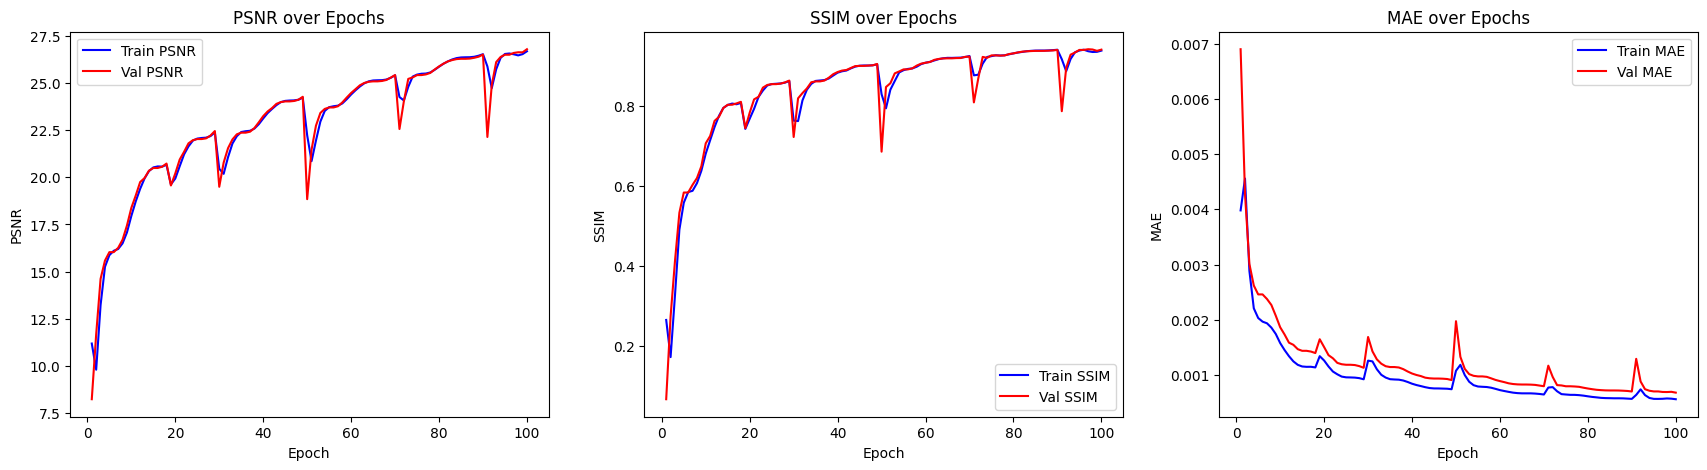

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pywt
from skimage.metrics import structural_similarity as ssim, peak_signal_noise_ratio as psnr

class WaveletTransform(nn.Module):
    def __init__(self):
        super(WaveletTransform, self).__init__()

    def forward(self, x):
        batch_size, channels, height, width = x.size()
        wavelet_coeffs = torch.zeros((batch_size, channels * 4, height, width), dtype=torch.float32).to(x.device)
        for i in range(batch_size):
            for j in range(channels):
                img = x[i, j].cpu().numpy()
                coeffs2 = pywt.dwt2(img, 'haar')
                LL, (LH, HL, HH) = coeffs2
                for k, coeff in enumerate([LL, LH, HL, HH]):
                    resized_coeff = torch.tensor(coeff).unsqueeze(0).to(x.device)
                    wavelet_coeffs[i, 4 * j + k] = nn.functional.interpolate(resized_coeff.unsqueeze(0), size=(height, width), mode='bilinear', align_corners=False).squeeze(0)
        return wavelet_coeffs

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        if in_channels != out_channels:
            self.match_channels = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1)
        else:
            self.match_channels = None

    def forward(self, x):
        residual = self.match_channels(x) if self.match_channels else x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += residual
        return self.relu(out)

class SubpixelDecoder(nn.Module):
    def __init__(self, in_channels, out_channels, upscale_factor=2):
        super(SubpixelDecoder, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels * (upscale_factor ** 2), kernel_size=3, padding=1)
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.relu(self.pixel_shuffle(self.conv(x)))

class EnhancedSeriesAutoencoder(nn.Module):
    def __init__(self):
        super(EnhancedSeriesAutoencoder, self).__init__()
        self.wavelet = WaveletTransform()
        self.encoder1 = ResidualBlock(12, 64)
        self.encoder2 = ResidualBlock(64, 128)
        self.encoder3 = ResidualBlock(128, 256)
        self.encoder4 = ResidualBlock(256, 512)
        self.decoder4 = SubpixelDecoder(512, 256)
        self.decoder3 = SubpixelDecoder(256, 128)
        self.decoder2 = SubpixelDecoder(128, 64)
        self.decoder1 = SubpixelDecoder(64, 12)
        self.final_conv = nn.Conv2d(12, 3, kernel_size=3, padding=1)

    def forward(self, x):
        wavelet_components = self.wavelet(x)
        enc1 = self.encoder1(wavelet_components)
        enc2 = self.encoder2(enc1)
        enc3 = self.encoder3(enc2)
        enc4 = self.encoder4(enc3)
        dec4 = self.decoder4(enc4)
        dec3 = self.decoder3(dec4 + nn.functional.interpolate(enc3, size=dec4.shape[2:], mode='bilinear', align_corners=False))
        dec2 = self.decoder2(dec3 + nn.functional.interpolate(enc2, size=dec3.shape[2:], mode='bilinear', align_corners=False))
        dec1 = self.decoder1(dec2 + nn.functional.interpolate(enc1, size=dec2.shape[2:], mode='bilinear', align_corners=False))
        return nn.functional.interpolate(self.final_conv(dec1), size=(32, 32), mode='bilinear', align_corners=False)

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
subset_indices = np.random.choice(len(train_dataset), 500, replace=False)
train_subset = Subset(train_dataset, subset_indices)
train_loader = DataLoader(train_subset, batch_size=64, shuffle=True, num_workers=2)

val_subset = Subset(train_dataset, subset_indices[:100])
val_loader = DataLoader(val_subset, batch_size=64, shuffle=False, num_workers=2)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = EnhancedSeriesAutoencoder().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0002)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5)
criterion = nn.MSELoss()

def train_model(model, train_loader, val_loader, optimizer, scheduler, num_epochs=20):
    model.train()
    train_psnr_values = []
    train_ssim_values = []
    train_mae_values = []
    val_psnr_values = []
    val_ssim_values = []
    val_mae_values = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        epoch_train_psnr = 0.0
        epoch_train_ssim = 0.0
        epoch_train_mae = 0.0
        epoch_val_psnr = 0.0
        epoch_val_ssim = 0.0
        epoch_val_mae = 0.0

        for inputs, _ in train_loader:
            inputs = inputs.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            inputs_np = inputs.cpu().numpy()
            outputs_np = outputs.cpu().detach().numpy()
            epoch_train_mae += np.mean(np.abs(inputs_np - outputs_np))

            for j in range(len(inputs)):
                input_img = np.transpose(inputs_np[j], (1, 2, 0))
                output_img = np.transpose(outputs_np[j], (1, 2, 0))
                epoch_train_psnr += psnr(input_img, output_img, data_range=1.0)
                epoch_train_ssim += ssim(input_img, output_img, data_range=1.0, multichannel=True, win_size=3)

        model.eval()
        with torch.no_grad():
            for inputs, _ in val_loader:
                inputs = inputs.to(device)
                outputs = model(inputs)

                inputs_np = inputs.cpu().numpy()
                outputs_np = outputs.cpu().detach().numpy()
                epoch_val_mae += np.mean(np.abs(inputs_np - outputs_np))

                for j in range(len(inputs)):
                    input_img = np.transpose(inputs_np[j], (1, 2, 0))
                    output_img = np.transpose(outputs_np[j], (1, 2, 0))
                    epoch_val_psnr += psnr(input_img, output_img, data_range=1.0)
                    epoch_val_ssim += ssim(input_img, output_img, data_range=1.0, multichannel=True, win_size=3)

        train_psnr_values.append(epoch_train_psnr / len(train_loader.dataset))
        train_ssim_values.append(epoch_train_ssim / len(train_loader.dataset))
        train_mae_values.append(epoch_train_mae / len(train_loader.dataset))
        val_psnr_values.append(epoch_val_psnr / len(val_loader.dataset))
        val_ssim_values.append(epoch_val_ssim / len(val_loader.dataset))
        val_mae_values.append(epoch_val_mae / len(val_loader.dataset))

        scheduler.step()
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(train_loader):.4f}, "
              f"Train PSNR: {train_psnr_values[-1]:.2f}, Train SSIM: {train_ssim_values[-1]:.4f}, "
              f"Val PSNR: {val_psnr_values[-1]:.2f}, Val SSIM: {val_ssim_values[-1]:.4f}, "
              f"Train MAE: {train_mae_values[-1]:.4f}, Val MAE: {val_mae_values[-1]:.4f}")

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21, 5))

    ax1.plot(range(1, num_epochs + 1), train_psnr_values, label='Train PSNR', color='b')
    ax1.plot(range(1, num_epochs + 1), val_psnr_values, label='Val PSNR', color='r')
    ax1.set_title('PSNR over Epochs')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('PSNR')
    ax1.legend()

    ax2.plot(range(1, num_epochs + 1), train_ssim_values, label='Train SSIM', color='b')
    ax2.plot(range(1, num_epochs + 1), val_ssim_values, label='Val SSIM', color='r')
    ax2.set_title('SSIM over Epochs')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('SSIM')
    ax2.legend()

    ax3.plot(range(1, num_epochs + 1), train_mae_values, label='Train MAE', color='b')
    ax3.plot(range(1, num_epochs + 1), val_mae_values, label='Val MAE', color='r')
    ax3.set_title('MAE over Epochs')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('MAE')
    ax3.legend()

    plt.show()

train_model(model, train_loader, val_loader, optimizer, scheduler, num_epochs=100)

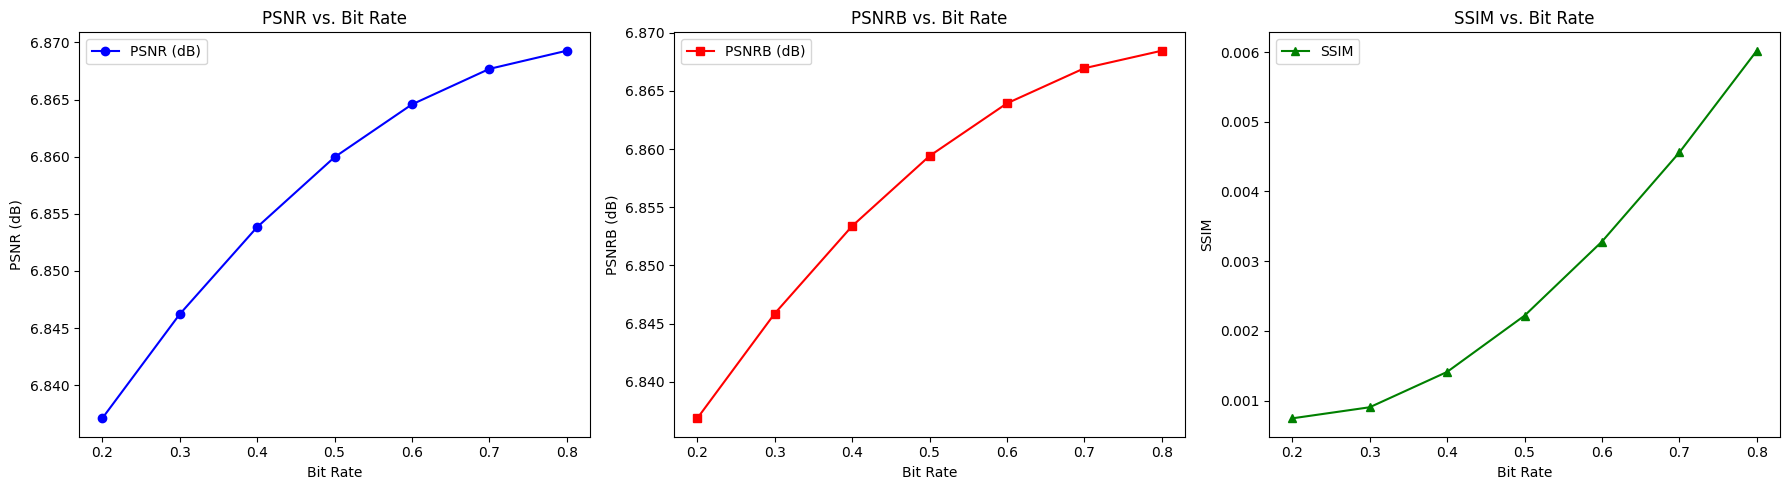

In [11]:
import cv2

bit_rates = np.arange(0.2, 0.9, 0.1)

def quality_measures(model, loader, bit_rates):
    psnr_values = {bit_rate: [] for bit_rate in bit_rates}
    psnrb_values = {bit_rate: [] for bit_rate in bit_rates}
    ssim_values = {bit_rate: [] for bit_rate in bit_rates}

    model.eval()
    with torch.no_grad():
        for bit_rate in bit_rates:
            for inputs, _ in loader:
                inputs = inputs.to(device)
                outputs = model(inputs)

                compressed_outputs = outputs * bit_rate

                inputs_np = inputs.cpu().numpy()
                compressed_outputs_np = compressed_outputs.cpu().detach().numpy()

                for j in range(len(inputs)):
                    input_img = np.transpose(inputs_np[j], (1, 2, 0))
                    compressed_img = np.transpose(compressed_outputs_np[j], (1, 2, 0))

                    psnr_value = psnr(input_img, compressed_img, data_range=1.0)
                    ssim_value = ssim(input_img, compressed_img, data_range=1.0, multichannel=True, win_size=3)

                    deblocked_img = cv2.GaussianBlur(compressed_img, (5, 5), 0)
                    psnrb_value = psnr(input_img, deblocked_img, data_range=1.0)

                    psnr_values[bit_rate].append(psnr_value)
                    ssim_values[bit_rate].append(ssim_value)
                    psnrb_values[bit_rate].append(psnrb_value)

    avg_psnr = {bit_rate: np.mean(values) for bit_rate, values in psnr_values.items()}
    avg_psnrb = {bit_rate: np.mean(values) for bit_rate, values in psnrb_values.items()}
    avg_ssim = {bit_rate: np.mean(values) for bit_rate, values in ssim_values.items()}

    return avg_psnr, avg_psnrb, avg_ssim

def plot_quality_measures(bit_rates, avg_psnr, avg_psnrb, avg_ssim):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    axes[0].plot(bit_rates, list(avg_psnr.values()), marker='o', color='b', label='PSNR (dB)')
    axes[0].set_title('PSNR vs. Bit Rate')
    axes[0].set_xlabel('Bit Rate')
    axes[0].set_ylabel('PSNR (dB)')
    axes[0].legend()

    axes[1].plot(bit_rates, list(avg_psnrb.values()), marker='s', color='r', label='PSNRB (dB)')
    axes[1].set_title('PSNRB vs. Bit Rate')
    axes[1].set_xlabel('Bit Rate')
    axes[1].set_ylabel('PSNRB (dB)')
    axes[1].legend()

    axes[2].plot(bit_rates, list(avg_ssim.values()), marker='^', color='g', label='SSIM')
    axes[2].set_title('SSIM vs. Bit Rate')
    axes[2].set_xlabel('Bit Rate')
    axes[2].set_ylabel('SSIM')
    axes[2].legend()

    plt.tight_layout()
    plt.show()

avg_psnr, avg_psnrb, avg_ssim = quality_measures(model, val_loader, bit_rates)
plot_quality_measures(bit_rates, avg_psnr, avg_psnrb, avg_ssim)

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import pywt
import numpy as np
import os
import tempfile
from PIL import Image
import torch.nn.functional as F

class WaveletTransform(nn.Module):
    def __init__(self):
        super(WaveletTransform, self).__init__()

    def forward(self, x):
        batch_size, channels, height, width = x.size()
        wavelet_coeffs = torch.zeros((batch_size, channels * 4, height // 2, width // 2), dtype=torch.float32).to(x.device)
        for i in range(batch_size):
            for j in range(channels):
                img = x[i, j].cpu().numpy()
                coeffs2 = pywt.dwt2(img, 'haar')
                LL, (LH, HL, HH) = coeffs2
                wavelet_coeffs[i, 4*j:4*j+4] = torch.tensor([LL, LH, HL, HH], device=x.device)
        return wavelet_coeffs

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.match_dims = nn.Conv2d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else None

    def forward(self, x):
        residual = x if self.match_dims is None else self.match_dims(x)
        x = F.relu(self.conv1(x))
        x = self.conv2(x) + residual
        return F.relu(x)

class SubpixelDecoder(nn.Module):
    def __init__(self, in_channels, out_channels, upscale_factor=2):
        super(SubpixelDecoder, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels * (upscale_factor ** 2), kernel_size=3, padding=1)
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor)

    def forward(self, x):
        return F.relu(self.pixel_shuffle(self.conv(x)))

class EnhancedSeriesAutoencoder(nn.Module):
    def __init__(self):
        super(EnhancedSeriesAutoencoder, self).__init__()
        self.wavelet = WaveletTransform()
        self.encoder1 = ResidualBlock(12, 64)
        self.encoder2 = ResidualBlock(64, 128)
        self.encoder3 = ResidualBlock(128, 256)
        self.encoder4 = ResidualBlock(256, 512)
        self.decoder4 = SubpixelDecoder(512, 256)
        self.decoder3 = SubpixelDecoder(256, 128)
        self.decoder2 = SubpixelDecoder(128, 64)
        self.decoder1 = SubpixelDecoder(64, 12)
        self.final_conv = nn.Conv2d(12, 3, kernel_size=3, padding=1)

    def forward(self, x):
        x = self.wavelet(x)
        x = self.encoder1(x)
        x = self.encoder2(x)
        x = self.encoder3(x)
        x = self.encoder4(x)
        x = self.decoder4(x)
        x = self.decoder3(x)
        x = self.decoder2(x)
        x = self.decoder1(x)
        return F.interpolate(self.final_conv(x), size=(32, 32), mode='bilinear')

transform = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

def load_image(image_path):
    img = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    return transform(img).unsqueeze(0)

def calculate_compression_metrics(original_path, compressed_tensor):
    original_size = os.path.getsize(original_path)
    with tempfile.NamedTemporaryFile(suffix=".jpg", delete=False) as temp_file:
        compressed_image_path = temp_file.name
    compressed_img = transforms.ToPILImage()(compressed_tensor.squeeze(0).cpu())
    compressed_img.save(compressed_image_path)
    compressed_size = os.path.getsize(compressed_image_path)
    reduction = original_size - compressed_size
    reduction_percentage = (reduction / original_size) * 100 if original_size != 0 else 0
    print(f"Original Size: {original_size / 1024:.2f} KB")
    print(f"Compressed Size: {compressed_size / 1024:.2f} KB")
    print(f"Reduction Percentage: {reduction_percentage:.2f}%")
    os.remove(compressed_image_path)

def compress_and_calculate_metrics(image_path, model):
    image_tensor = load_image(image_path).to(device)
    model.eval()
    with torch.no_grad():
        compressed_tensor = model(image_tensor)
    calculate_compression_metrics(image_path, compressed_tensor)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = EnhancedSeriesAutoencoder().to(device)

image_path = '/kaggle/input/sdfghjk/image1.png'
compress_and_calculate_metrics(image_path, model)

Original Size: 201.59 KB
Compressed Size: 0.63 KB
Reduction Percentage: 99.69%


100%|██████████| 170498071/170498071 [00:02<00:00, 82361600.73it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


NameError: name 'Subset' is not defined